In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
import scipy
from scipy.integrate import odeint
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
import pysindy as ps
import pandas as pd
from matplotlib import cm

In [2]:
#SINDy setup
poly_order =5 # sindy equation order
threshold =0.0000002#0.0000001#0.002 #0.05 #hyperparameter to control level of sensisitivity 
smoothed_fd=ps.SmoothedFiniteDifference() # dofferentatin method to smooth noise
#sr3_optimizer = ps.SR3(threshold=0.1,thresholder='l0') #optimizer sr3

# poly_library = ps.PolynomialLibrary(degree=poly_order)
# custom_library = ps.CustomLibrary(
# library_functions=library_functions
# )
#combined_library = poly_library + custom_library
                                           
modelSPB = ps.SINDy(
    #optimizer=ps.SR3(threshold=threshold,thresholder='l0'),
    optimizer=ps.STLSQ(threshold=threshold),
    #feature_library=combined_library,
    feature_library=ps.PolynomialLibrary(degree=poly_order),
    differentiation_method=smoothed_fd
)

In [ ]:
#Parameter setup
b=0.00#4#0.004
epsilon=0.05#0.01
z=.75# Decision threshold
tauX=20
c=0.01# Size of the noise
dt=.01#timestep
x0=[0]#initial_condition
q0=[0.01]
#Trial_total=1 #Total number of trial
T_Total=20000 #Total time

Model_total=1
Trial_total=Model_total #Total number of trial

In [10]:
#SPB simulation setup

coef_mat=[]
error_trials=[]

#model/trial loop
for model in range(Model_total):
    t = np.arange(0, T_Total, dt)
    x = np.zeros_like(t)
    error=False
    
    for p in range(len(x)-1):        
        x[p+1] = x[p]+(dt/tauX)*((epsilon*x[p])+(x[p]**3)-(x[p]**5)+b)+ c*np.sqrt((dt/tauX))*np.random.randn()
        #x[p+1]/=tauX

        if x[p]>=z: #or x[p]<0:# Condition for making the correct response  
            x=x[0:p+1]
            break # Stop the time "for" loop  
        elif x[p]<=-z: #or y[p]<0:# Condition for making the error response   
            x=x[0:p+1]
            error=True
            break # Stop the time "for" loop 
    x_data_1= x
    #fit model
    modelSPB.fit(x_data_1, t=dt/tauX)
    
#below is a simultaion using sindy's simulate feature, was removed as it was casuing errors and contained black box codes
#******will need to implement prediction error with manual codes*******
#     x_sim = modelSPB.simulate(x0, t) #simulate data
#     #print(x_sim)

#     #cut simulated data when it passes decision threshold
#     q=[]
#     for v in range(np.size(x_sim,0)):
#         #print(v)
#         q.append(x_sim[i,0])
#         if x_sim[i]>=z :
#             if error==True:
#                 error_trials.append(0)
#                 break
#             elif error==False :
#                 error_trials.append(1)
#                 break
#         elif x_sim[i]<=-z :
#              if error==False:
#                 error_trials.append(0)
#                 break
#              elif error==True :
#                 error_trials.append(1)
#                 break
    
#     x_sim_1= np.array(q)

    modelSPB.print()
    coef_mat.append(modelSPB.coefficients())

coef_mat=np.array(coef_mat)
coef_mat=coef_mat.reshape(Model_total,1*6)
#print(coef_mat.shape)
coef_panda=pd.DataFrame(coef_mat, columns=['$x^0$','$x^1$','$x^2$','$x^3$','$x^4$','$x^5$'])

(x0)' = -0.001 1 + 0.088 x0 + 0.229 x0^2 + 1.512 x0^3 + 0.558 x0^4 + -0.797 x0^5


# Simulation vs Real data

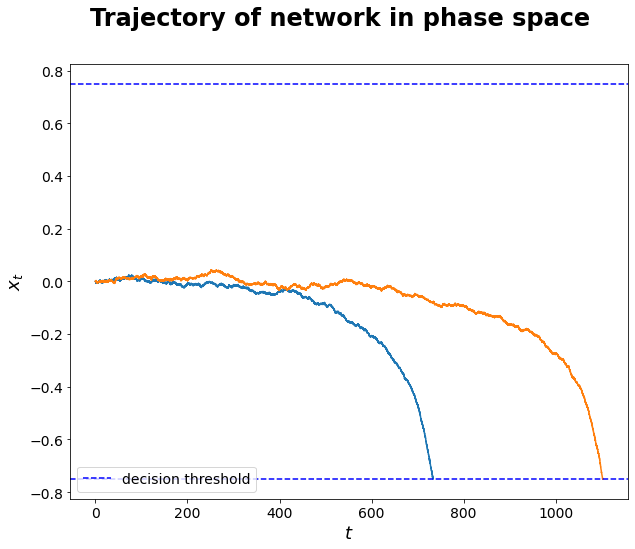

In [11]:
sim = np.zeros_like(t)
coef_0=coef_panda.values[0,0]
coef_1=coef_panda.values[0,1]
coef_2=coef_panda.values[0,2]
coef_3=coef_panda.values[0,3]
coef_4=coef_panda.values[0,4]
coef_5=coef_panda.values[0,5]


for h in range(len(sim)-1):        
    sim[h+1] = sim[h]+(dt/tauX)*(coef_0+(coef_1*sim[h])+(coef_2*sim[h]**2)+(coef_3*sim[h]**3)+(coef_4*sim[h]**4)
                                 +(coef_5*sim[h]**5))+ c*np.sqrt((dt/tauX))*np.random.randn()
    #x[p+1]/=tauX

    if sim[h]>=z: #or x[p]<0:# Condition for making the correct response  (since S1>S2)
        sim=sim[0:h+1]
        break 
    elif sim[h]<=-z: #or y[p]<0:# Condition for making the error response  (since S2>S1)   
        sim=sim[0:h+1]
        error=True
        break
    x_sim_test=sim
    
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)
f.suptitle('Trajectory of network in phase space',fontsize=24, fontweight='bold')
plt.plot(t[:len(sim)],sim)
#plt.plot([-1,-1],[1,1]) 
#print(x_data_1)
plt.plot(t[:len(x-1)],x)
#plt.axvline(x=z,linestyle="dashed", color="blue", label="decision threshold")
plt.axhline(y=z,linestyle="dashed", color="blue" ,label="decision threshold")
plt.axhline(y=-z,linestyle="dashed", color="blue")
plt.xlabel("$t$",fontsize=18)
plt.ylabel("$x_t$",fontsize=18)
plt.rcParams.update({'font.size': 14})
plt.legend(loc="lower left")

In [343]:
print("number of trials:" + str(len(error_trials)))
print(error_trials)
print("number of error trials:"+str(error_trials.count(0)))
if error_trials.count(0)!= 0 :
    print("error perecentage:"+str((error_trials.count(0))/(len(error_trials))*100))

number of trials:0
[]
number of error trials:0


In [361]:
coef_panda.mean()

$x^0$    0.004000
$x^1$    0.050000
$x^2$   -0.000032
$x^3$    1.000254
$x^4$   -0.001238
$x^5$   -0.998758
dtype: float64

In [372]:
print(x_sim_1)

[0.01018022 0.01018022 0.01018022 ... 0.01018022 0.01018022 0.01018022]


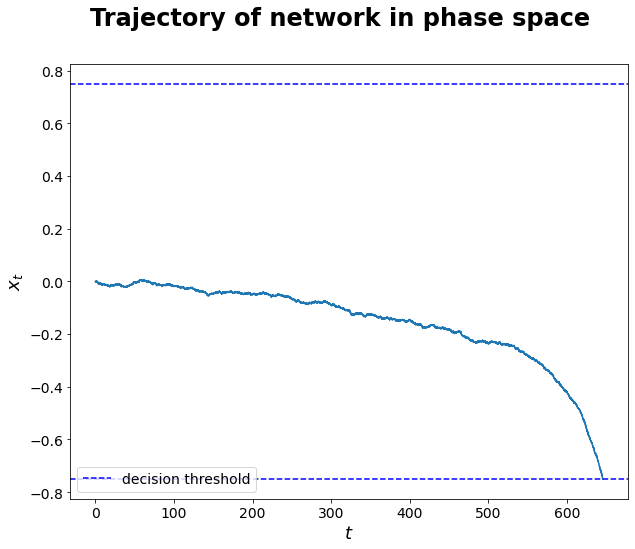

In [6]:
#graphs
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)
f.suptitle('Trajectory of network in phase space',fontsize=24, fontweight='bold')
#plt.plot(t[:len(sim)],sim)
#plt.plot([-1,-1],[1,1]) 
#print(x_data_1)
plt.plot(t[:len(x-1)],x)
#plt.axvline(x=z,linestyle="dashed", color="blue", label="decision threshold")
plt.axhline(y=z,linestyle="dashed", color="blue" ,label="decision threshold")
plt.axhline(y=-z,linestyle="dashed", color="blue")
plt.xlabel("$t$",fontsize=18)
plt.ylabel("$x_t$",fontsize=18)
plt.rcParams.update({'font.size': 14})
plt.legend(loc="lower left")

In [362]:
print(len(q))
print(len(x))

2000000
60491


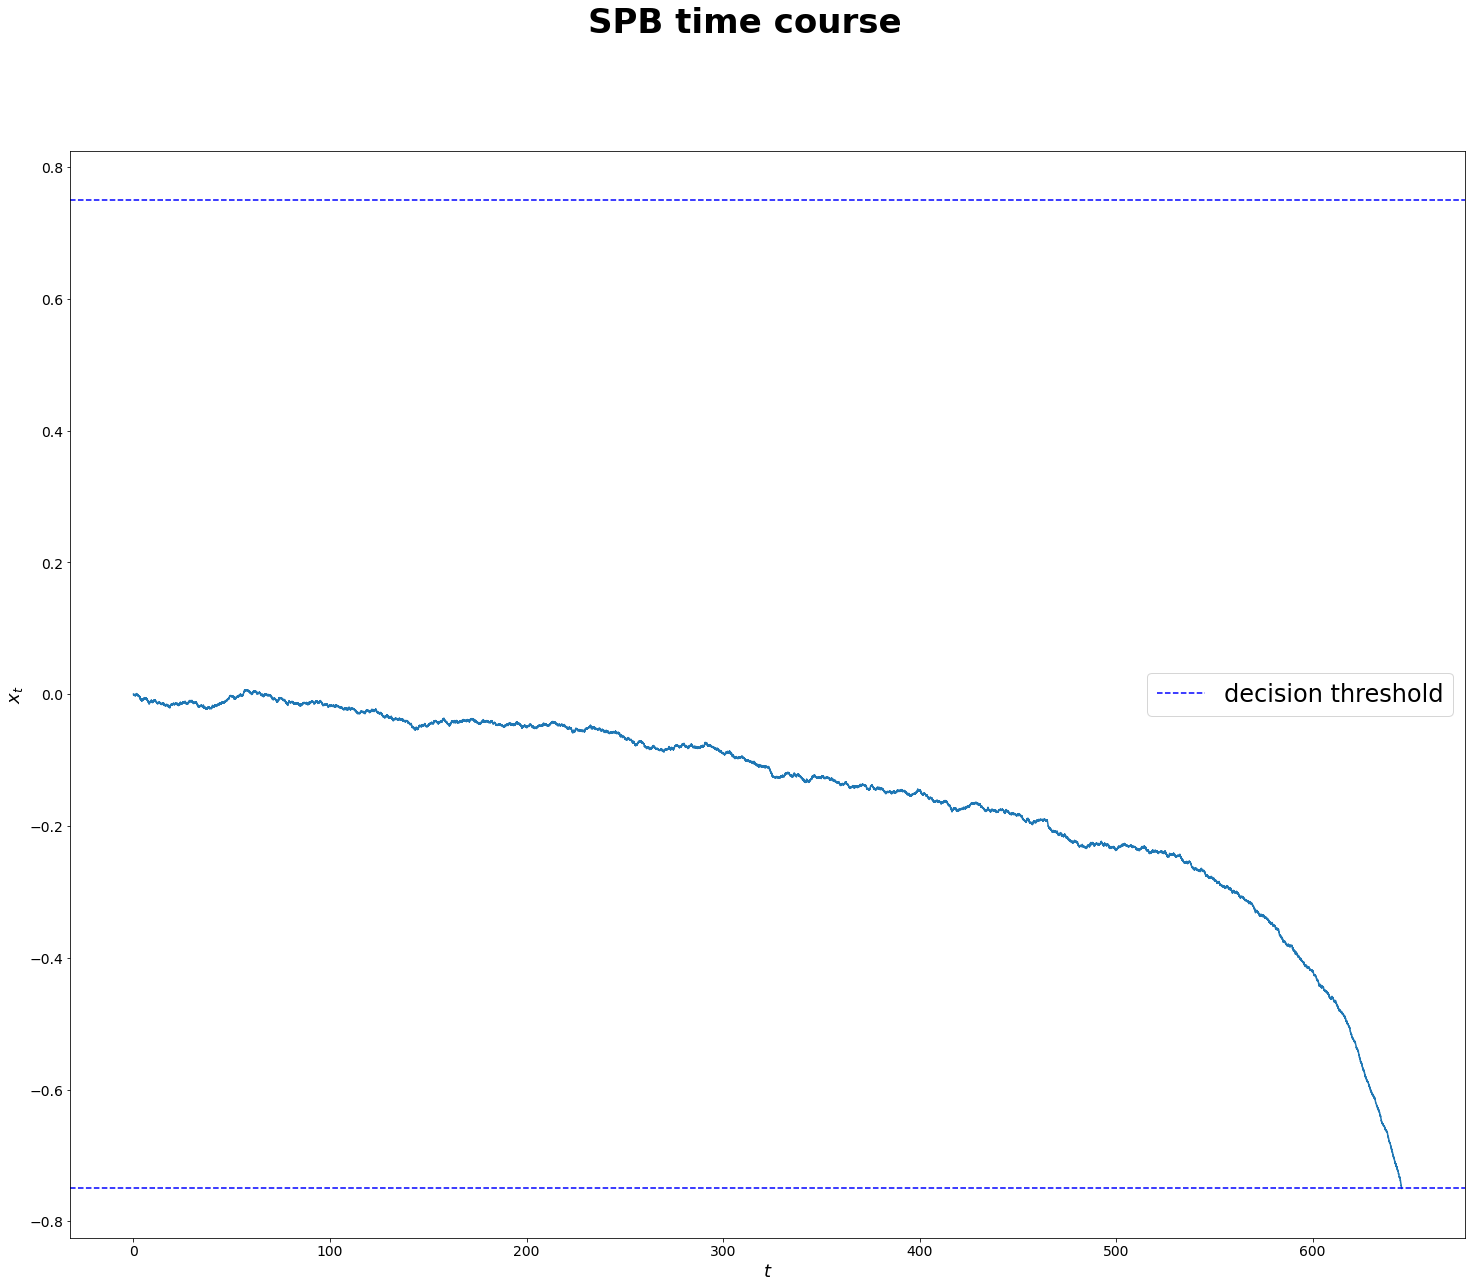

In [7]:
# #graphs
f = plt.figure()
f.set_figwidth(25)
f.set_figheight(20)
f.suptitle('SPB time course',fontsize=34, fontweight='bold')
#print(x_data_1)
plt.plot(t[:len(x-1)],x)
#plt.axvline(x=z,linestyle="dashed", color="blue", label="decision threshold")
plt.axhline(y=z,linestyle="dashed", color="blue" ,label="decision threshold")
plt.axhline(y=-z,linestyle="dashed", color="blue")
plt.xlabel("$t$",fontsize=18)
plt.ylabel("$x_t$",fontsize=18)
plt.rcParams.update({'font.size': 24})
plt.legend(loc=7)  

In [152]:
#=coef_panda
#trail_50 noise is 0.1 and other 0.01
trial_50_less_noise.mean()

$x^0$    0.000135
$x^1$    0.017470
$x^2$    0.369601
$x^3$    1.689369
$x^4$    1.849477
$x^5$    0.397256
dtype: float64

In [148]:
trial_50.mean()

$x^0$    -0.001152
$x^1$     0.786455
$x^2$     6.580227
$x^3$    36.387396
$x^4$    45.902128
$x^5$    37.308980
dtype: float64

In [145]:
#trial_50=coef_panda
#noise=0.1 for trial 10
trial_10

,$x^0$,$x^1$,$x^2$,$x^3$,$x^4$,$x^5$
0,-0.000744,0.010464,0.013742,-0.287637,-0.050197,1.577866
1,0.000820,0.010027,-0.003481,-0.184743,-0.055039,0.744784
2,0.000688,0.005652,-0.035689,-0.216035,0.338692,1.690239
3,-0.000262,0.000610,0.011574,-0.010217,-0.077558,0.000000
4,-0.000877,0.007737,0.011601,-0.116497,-0.029937,0.338714
5,-0.000609,0.015757,-0.063889,-0.199017,0.614601,1.161529
6,0.000000,0.000000,0.000630,0.002133,-0.008669,-0.023120
7,-0.000496,0.001753,0.027316,-0.067189,-0.259808,0.592120
8,-0.000757,0.006180,0.025661,-0.145236,-0.164825,0.721326
9,-0.000783,0.004904,0.036246,-0.153737,-0.319023,1.078620


In [91]:
trial_10.mean()

$x^0$   -0.000302
$x^1$    0.006308
$x^2$    0.002371
$x^3$   -0.137818
$x^4$   -0.001176
$x^5$    0.788208
dtype: float64

In [92]:
trial_10.std()

$x^0$    0.000617
$x^1$    0.004920
$x^2$    0.030709
$x^3$    0.091973
$x^4$    0.279168
$x^5$    0.595101
dtype: float64

In [93]:
# x_0=coef_panda["$x^0$"]
# x_1=coef_panda["$x^1$"]
# x_2=coef_panda["$x^2$"]
# x_3=coef_panda["$x^3$"]
# x_4=coef_panda["$x^4$"]
# x_5=coef_panda["$x^5$"]

x_0=trial_10["$x^0$"]
x_1=trial_10["$x^1$"]
x_2=trial_10["$x^2$"]
x_3=trial_10["$x^3$"]
x_4=trial_10["$x^4$"]
x_5=trial_10["$x^5$"]

<AxesSubplot:xlabel='Coefficent Value', ylabel='Density'>

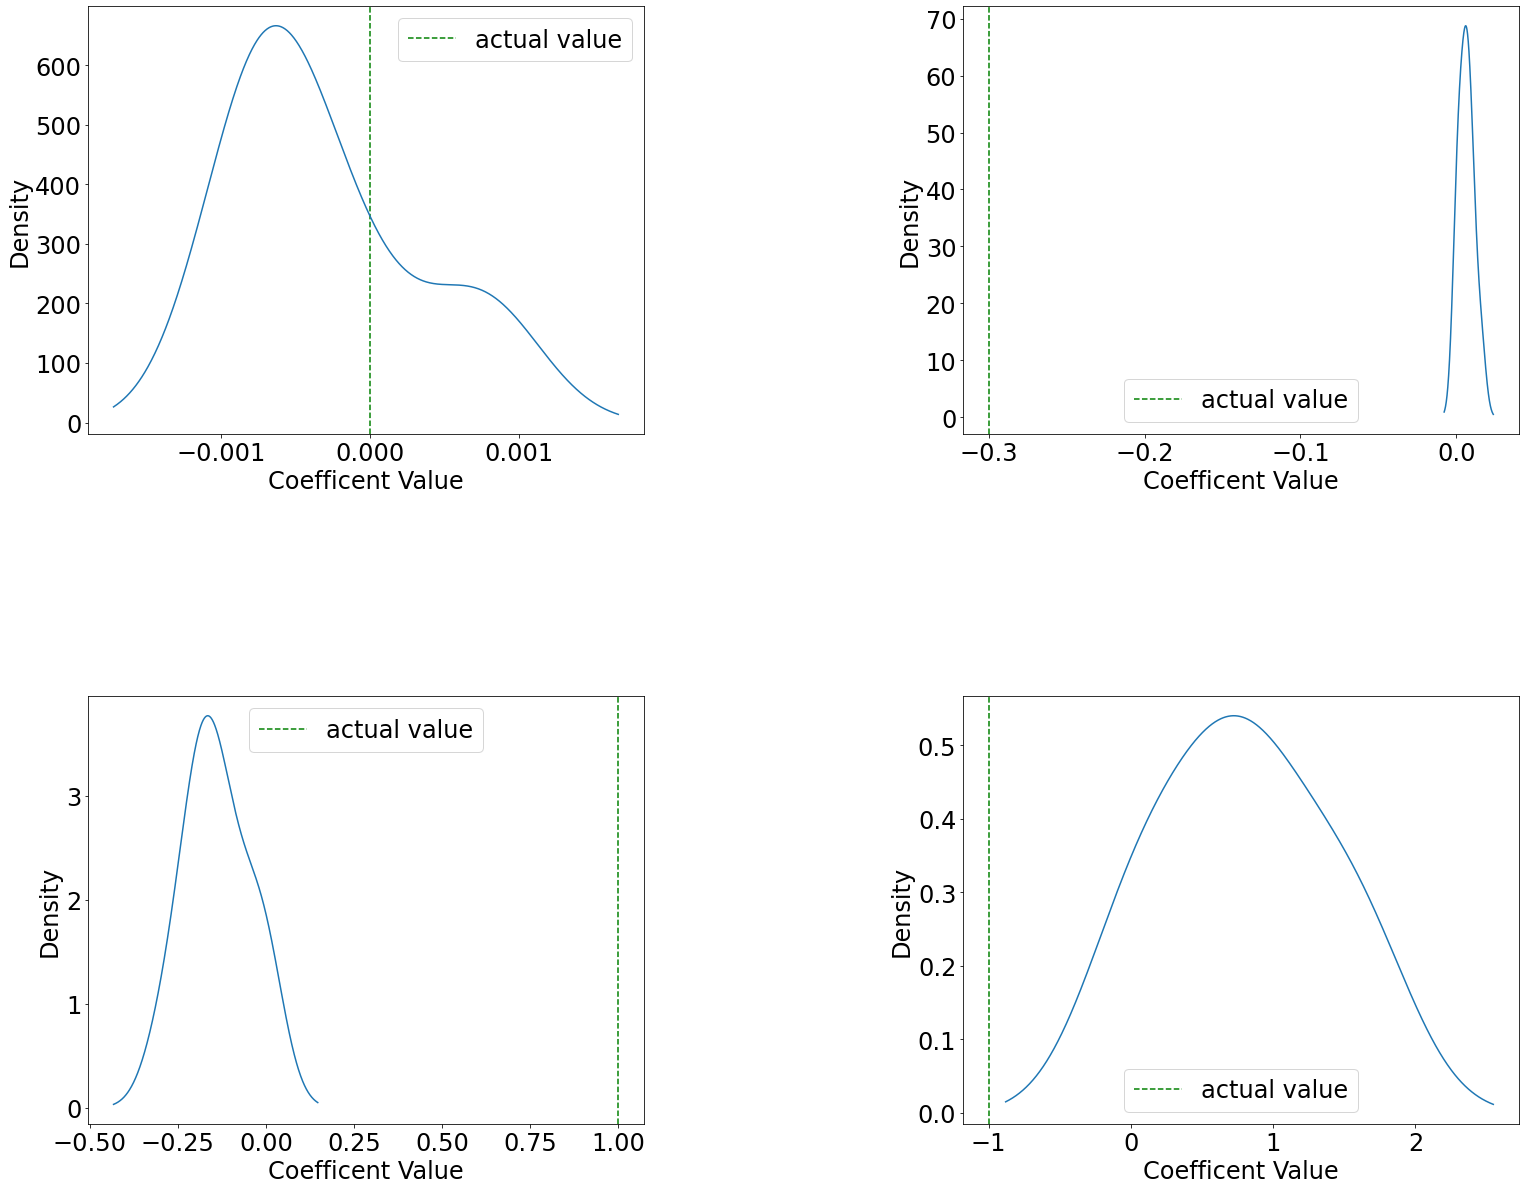

In [94]:
figure, axes = plt.subplots(2, 2)
figure.tight_layout(pad=0.5)
figure.set_figwidth(25)
figure.set_figheight(20)
plt.rcParams.update({'font.size': 24})
axes[0,0].axvline(x=0,linestyle="dashed", color="green" ,label='actual value')
axes[0,0].legend(loc="upper center")
axes[0,0].set(xlabel="Coefficent Value")

axes[0,1].axvline(x=epsilon,linestyle="dashed", color="green" ,label='actual value')
axes[0,1].legend(loc="upper center")
axes[0,1].set(xlabel="Coefficent Value")

axes[1,0].axvline(x=1,linestyle="dashed", color="green" ,label='actual value')
axes[1,0].legend(loc="upper center")
axes[1,0].set(xlabel="Coefficent Value")

axes[1,1].axvline(x=-1,linestyle="dashed", color="green" ,label='actual value')
axes[1,1].legend(loc="upper center")
axes[1,1].set(xlabel="Coefficent Value")

x_0.plot.kde(ax=axes[0,0])
x_1.plot.kde(ax=axes[0,1])
x_3.plot.kde(ax=axes[1,0])
x_5.plot.kde(ax=axes[1,1])

In [1]:
trial_50=coef_panda
trial_50

NameError: name 'coef_panda' is not defined

In [44]:
# #error
# b_error=abs(b-coef_panda["$x^0$"].mean())
# eps_error=abs(epsilon-coef_panda["$x^1$"].mean())
# x3_error=abs(1-coef_panda["$x^3$"].mean())
# x5_error=abs(-1-coef_panda["$x^5$"].mean())
# print(b_error)
# print(eps_error)
# print(x3_error)
# print(x5_error)

0.0011215716843778487
0.0025397601643466217
0.4240415803706046
0.640521479399053


In [ ]:
#coef_panda.plot.kde(subplots=True, figsize=(20, 40)); plt.legend(loc='best')
# # Generate Gaussian
# px =scipy.stats.norm(coef_panda["$x^4$"].mean(), coef_panda["$x^4$"].std())
# gaus=np.arange(-2.5,2.5,0.1)
# # Visualize
#plt.plot(gaus, px.pdf(gaus))

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(coef_panda["$x^0$"], coef_panda["$x^3$"], coef_panda["$x^5$"], 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('3D contour')
plt.show()